# $P(n)$: Multivariate Model Mixing 

## Alexandra Semposki

### Date last edited: 30 January 2024

We would like to model mix the chiral EFT EOS with the perturbative QCD EOS for Symmetric Nuclear Matter (SNM) using an interpolant between the two regions of model validity. First we set up the two models as `dict`s and then we employ a simple Gaussian Process (GP) to handle the interpolation between the two.

#### Table of contents

1. [Bayesian Model Mixing via Taweret](#bmm_taweret)
  1. [Speed of sound calculaton](#cs2_taweret)
1. [Bayesian Model Mixing as a GP](#bmm_gp) 
  1. [Speed of sound calculation](#cs2_gp)

__NOTE__: Anywhere you see '!!!' in the comments, those are sections under construction that need cleaning up.

# STOP. 

Have you checked that you're on the correct branch of Taweret?

In [28]:
# import packages
%load_ext autoreload
%autoreload 2

import gsum as gm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as scint
import scipy.interpolate as scinterp
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
import scipy.stats as stats
import os
import sys
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize as opt
import pandas as pd
from collections import defaultdict
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# import Taweret
import sys
sys.path.append('../../Taweret')  # Taweret needs to be a pip package (I know, work in progress)
sys.path.append('src/')
sys.path.append('data/')

# import from Taweret all modules
from Taweret.core.base_model import BaseModel
from Taweret.mix.gaussian import Multivariate

In [30]:
# import plotting script from J. Melendez
from scripts import *
setup_rc_params()

In [31]:
# import classes for chiral and pQCD
from chiral_model import Chiral_model
from pqcd_reworked import PQCD
from gorda_model import Gorda

# import class to wrap gsum
from truncation_error import Truncation

# import class for speed of sound calculation
from utils import speed_of_sound

## Bayesian Model Mixing via Taweret <a id="bmm_taweret"></a>

In [32]:
# design the GP class we'll need for the interpolant (using GPJaxEmcee results)
class GP_model(BaseModel):
    
    def __init__(self, density, gp_dict):     #tr_data, std_dev_pqcd, force_equal=False):
        
        # import the data set here
        gp_test = gp_dict
        self.dens_test = gp_test['density']
        self.dens_log = gp_test['dens_log']
        self.mean_test = gp_test['mean']
        self.std_test = gp_test['std']
        self.cov_test = gp_test['cov']
        
        # check density to match
        print(np.allclose(density,self.dens_test))
        
        # first pqcd point in the tr_data
#        pqcd_cut = tr_data['density'][2]
        
#         # check condition
#         if force_equal is True:
#             index_cut = np.where(pqcd_cut >= gp_test['density'])[0][-1]
            
#             # from here, replace with pqcd real variances
#             std_pqcd = std_dev_pqcd[::2]
#             for i in range(len(self.dens_test)):
#                 if i <= 60:
#                     self.std_test[i] = gp_test['std'][i]
#                 elif i > 60:
#                     self.std_test[i] = std_pqcd[i]
                
        return None
    
    # mean and std here imported from data set
    def evaluate(self, density):
        
        # return the arrays for mixing from the GP
        return self.mean_test, self.std_test
    
    # define prior function
    def set_prior(self):       
        return None 
    
    # define likelihood
    def log_likelihood_elementwise(self):       
        return None

### Training data and model evaluations

Here the models are both evaluated at every training and testing point we'll be using, so that we can save this data and pick the proper training points and testing points for the GP later on.

In [33]:
# define density linspace for training and testing
density = np.linspace(0.16, 16.0, 600)  # now starting from saturation

#instantiate pqcd EOS
pqcdk = PQCD(X=1,Nf=2) # X=1 standard for now; Nf=2 for two flavours of quarks

# take the density and invert to obtain the corresponding mu
n_q = density*3.0  # n_q [fm^-3]

# convert to GeV^3 for mu_q units
conversion_fm3 = ((1000.0)**(3.0))/((197.327)**(3.0)) # [fm^-3]  (do the opposite of this)
n0 = 0.16 
n_q = n_q/conversion_fm3

# invert for mu_FG and mu corresponding to chosen n_B
_, mu_n, mu_FG = pqcdk.inversion(n_mu=n_q)

# evaluate model (N2LO only) !!!
pqcd = Gorda(mu=mu_n, X=1, Nf=2, mu_FG=mu_FG)
mean_pqcd, std_dev_pqcd = pqcd.evaluate(N2LO=True, scaled=True)

# instantiate the chiral EOS
chiral = Chiral_model(density=density, Lambda=500, high_density=True)

# evaluate model (N3LO only) !!!
mean_chiral, std_dev_chiral = chiral.evaluate(N3LO=True, scaled=True, extend=True) # extend for truncation bands

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


RBF(length_scale=17.5) + WhiteKernel(noise_level=0.000105)
3.7869366481954367


/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/gsum/models.py:1340: RuntimeWarning: invalid value encountered in multiply
  return self.ref(X) * ratio_sum * coeff_mean


Setting up neutron matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8
Setting up nuclear matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 6
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 7
Setting up symmetry energy...
0.973 0.484 0.8119689713375328
For EFT order 0, the best polynomial has max nu = 7


/Users/alexandra/Documents/EOSBMM/buqeyenm/../buqeyenm/nuclear-matter-convergence/nuclear_matter/derivatives.py:318: RuntimeWarning: invalid value encountered in sqrt
  d[i] = np.sqrt(np.diag(cov_ij))


For EFT order 2, the best polynomial has max nu = 7
For EFT order 3, the best polynomial has max nu = 7
For EFT order 4, the best polynomial has max nu = 7
Setup time: 88.06596088409424


In [34]:
# load training data from GPJaxEmcee calculation for plotting
tr_data = np.load('data/gpjaxemcee_data/gp_ls2_training_log.npz')
print(len(tr_data['mean']))

# load the GP evaluation data from GPJaxEmcee
gp_result = np.load('data/gpjaxemcee_data/gp_ls2_log.npz')
print(len(gp_result['mean']))

7
300


In [35]:
# instantiate GP model
density_test = density[::2]
gp_model = GP_model(density_test, gp_result)

True


In [36]:
# set up new chiral class for running with pre-selected data
class Chiralmodel(BaseModel):
    
    def __init__(self, density_test, mean_test, std_dev_test):
        
        self.density_test = density_test
        self.mean_test = mean_test
        self.std_dev_test = std_dev_test
        
        return None
    
    def evaluate(self, density):
        
        return self.mean_test, self.std_dev_test
    
    def log_likelihood_elementwise(self):
        return None
    def set_prior(self):
        return None
    
class PQCDmodel(BaseModel):
    
    def __init__(self, density_test, mean_test, std_dev_test):
        
        self.density_test = density_test
        self.mean_test = mean_test
        self.std_dev_test = std_dev_test
        
        return None
    
    def evaluate(self, density):
        return self.mean_test, self.std_dev_test
    
    def log_likelihood_elementwise(self):
        return None
    def set_prior(self):
        return None
    
# instantiate both of these models for mixing
chiral_mixing = Chiralmodel(density_test, mean_chiral[::2], std_dev_chiral[::2])
pqcd_mixing = PQCDmodel(density_test, mean_pqcd[::2], std_dev_pqcd[::2])

(300,)


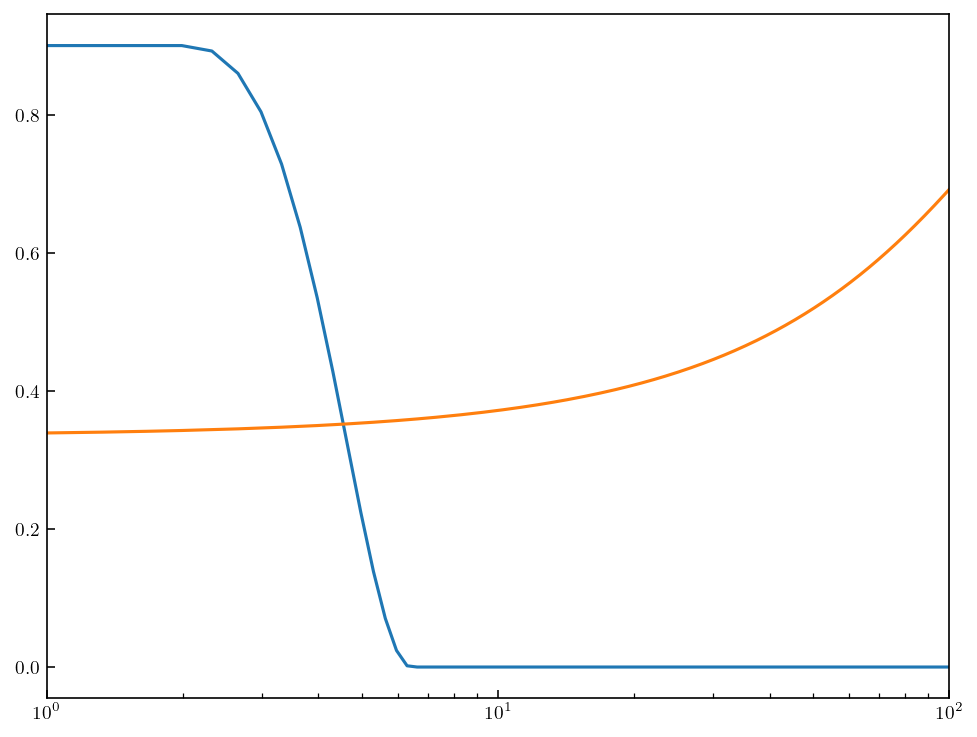

In [37]:
# play with some piecewise cosine parameterisations for the chiral side
def piecewisecos(g, g1, g2, g3):
        
    if g1 > g2 or g2 < g3 or g1 > g3:
        return -np.inf

    if g <= g1:
        return 1.0

    elif g <= g3:
        return (1.0 + np.cos((np.pi/2.0) * ((g - g1)/(g3 - g1))))/2.0

    elif g < g2:
        return 0.5 + np.cos((np.pi/2.0) * (1.0 + ((g - g3)/(g2 - g3))))/2.0

    else:
        return 0.0
    
# play with some piecewise cosine parameterisations for the pQCD side
def inv_piecewisecos(g, g1, g2, g3):
        
    if g1 > g2 or g2 < g3 or g1 > g3:
        return -np.inf

    if g <= g1:
        return 0.0

    elif g <= g3:
        return 1.0 -(1.0 + np.cos((np.pi/2.0) * ((g - g1)/(g3 - g1))))/2.0

    elif g < g2:
        return 1.0 - (0.5 + np.cos((np.pi/2.0) * (1.0 + ((g - g3)/(g2 - g3))))/2.0)

    else:
        return 1.0
    
# use the chiral EFT lengthscale to determine the width of the crossover region
cosine = np.zeros(len(density_test))
inv_cosine = np.zeros(len(density_test))
for i in range(len(density_test)):
    cosine[i] = piecewisecos(density_test[i], 0.33, 0.33+2*0.348, 0.33+0.348)
    inv_cosine[i] = inv_piecewisecos(density_test[i], 5.0-30.5, 5.0+30.5, 5.0)
plt.plot(density_test/n0, 0.9*cosine)
plt.plot(density_test/n0, 0.9*inv_cosine)
plt.xscale('log')
plt.xlim(1.0, 1e2)
print(cosine.shape)

In [38]:
# mix our models by setting them up and sending to Taweret
models = {
    "chiral" : chiral_mixing,
    "pqcd" : pqcd_mixing,
    "gp" : gp_model
}

# instantiate Multivariate class (using testing density array)
mixed_model = Multivariate(density_test, models, n_models=len(models))

# call predict
# set up the correlation parameter arrays
R = 0.8*cosine
S = 0.8*inv_cosine
_, mixed_mean, mixed_intervals, mixed_std_dev = mixed_model.predict(ci=68)

TypeError: predict() got an unexpected keyword argument 'correlated'

In [ ]:
# check the kernel from pQCD just in case
print(pqcd.trunc.kernel)

---

In [ ]:
# use the conversion from the pQCD code to see if this resolves things
convert_pqcd = np.load('pqcd_fg_data.npz')

# interpolate for a functional form to use 
convert_interp = scinterp.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
pqcd_convert_arr = convert_interp(density_test)

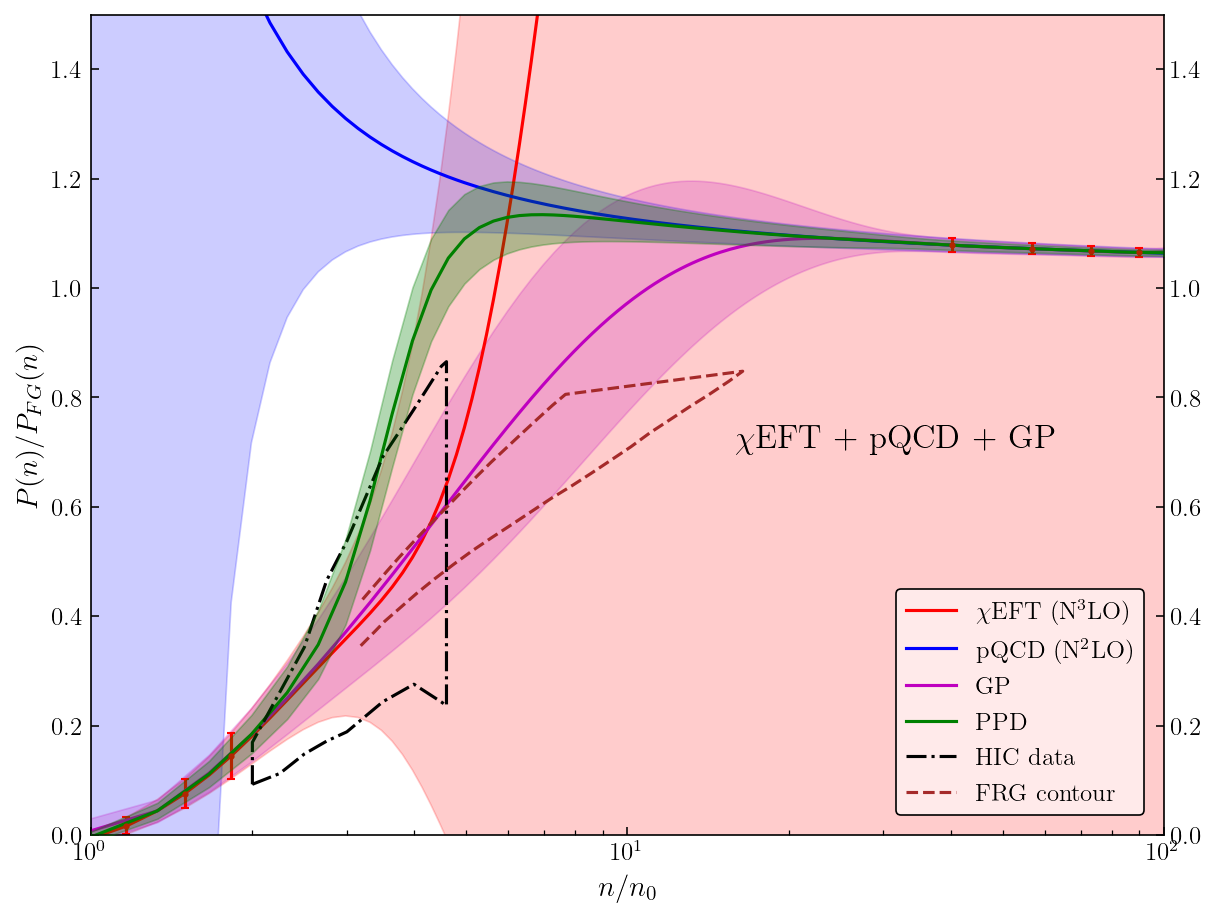

In [15]:
# plot BMM result
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(1., max(density/n0))
ax.set_ylim(0.0,1.5)
ax.tick_params(axis='both', which='major', labelsize=12, labelright=True, right=True)
ax.tick_params(axis='both', which='minor', labelsize=10, labelright=True)
ax.text(0.9,0.5, r'$\chi$EFT + pQCD + GP', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)

colors = ['r', 'b', 'g']
labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed model']

# model means
ax.plot(density/n0, mean_chiral, color=colors[0], label=labels[0])
ax.plot(density/n0, mean_pqcd, color=colors[1], label=labels[1])
ax.plot(density_test/n0, gp_result['mean'], color='m', label=r'GP')

# PPD mean (testing data array)
ax.plot(density_test/n0, mixed_mean, color='g', label='PPD')

# model uncertainties
ax.fill_between(density/n0, mean_chiral - 1.0*std_dev_chiral, mean_chiral + 1.0*std_dev_chiral, color=colors[0], alpha=0.2)
ax.fill_between(density/n0, mean_pqcd - 1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                color=colors[1], alpha=0.2)
ax.fill_between(density_test/n0, gp_result['mean']-1.0*gp_result['std'], gp_result['mean']+1.0*gp_result['std'], color='m', alpha=0.2)

# PPD band (testing data array)
ax.fill_between(density_test/n0, mixed_mean-1.0*mixed_std_dev, mixed_mean+1.0*mixed_std_dev,
                        zorder=5, facecolor='g', edgecolor='g', alpha=0.3)

# import contours and plot
df = pd.read_csv('data/contour_scaled.csv')
df_frg = pd.read_csv('data/frg_data_pressure.csv')
df_hhic = pd.read_csv('data/hic_data_huth.csv')
df_hfrg = pd.read_csv('data/frg_data_huth.csv')

# frg unscaling
pressure_free = np.zeros([len(df_frg['n/n0'])])
p_fg = np.zeros([len(density_test)])
hbarc = 197.327 # MeV fm

# contour kf_s calculated here 
from nuclear_matter import fermi_momentum, nuclear_density
contour_kf_s_fg = fermi_momentum(density=density_test, degeneracy=4)
contour_kf_s = fermi_momentum(density=0.16*df_frg['n/n0'], degeneracy=4)
for i in range(len(df_frg['n/n0'])):
    pressure_free[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s[i]**4.0))*(hbarc)
for i in range(len(density_test)):
    p_fg[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s_fg[i]**4.0))*(hbarc)
    
# unscale FRG
frg_unscaled = df_frg['P/P_free']*pressure_free
ax.plot(df['Density/n0'], df['p_pfg'], color='k', linestyle='dashdot', label='HIC data')
ax.plot(df_frg['n/n0'], df_frg['P/P_free'], color='brown', linestyle='dashed', label='FRG contour')

# plot the training points
plt.errorbar(tr_data["density"]/n0, tr_data["mean"], yerr=tr_data["std"], \
             color='red', fmt='o', markersize=2, capsize=2)

# legend
ax.set_xscale('log')
ax.legend(loc='lower right', fontsize=12)
plt.show()

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="cs2_taweret"></a>

We need to extract the speed of sound from the pressure equation. The most direct way to do this is to integrate the $P(n)$ curve to get the energy density. 

$$
P(n) = n^{2} \frac{\partial (\varepsilon/n)}{\partial n}
$$

$$
\varepsilon(n) = n \left[\int_{min(n)}^{n} \frac{P(n)}{n^{2}} dn + \frac{\varepsilon(min(n))}{min(n)} \right],
$$

where $min(n)$ is 0.05 fm$^{-3}$, and $max(n)$ is 16.0 fm$^{-3}$.

After we achieve the energy density in this manner, we will then code the chemical potential as

$$
\mu = \frac{P(n) + \varepsilon(n)}{n},
$$

and finally obtain the speed of sound, given as

$$
c_{s}^{2}(n) = \frac{\partial P}{\partial n } / \frac{\partial \varepsilon}{\partial n} = \frac{1}{\mu} \frac{\partial P(n)}{\partial n}.
$$

In [16]:
# integration for energy density using Simpson's Rule !!!

# mean
en_0 = 147.9713083195 #46.52745253488445 # when rest mass is included for ChEFT at 0.05 fm^-3
en_0_lower = 147.835229682 #46.525
en_0_upper = 148.1073869568 #46.530
# en_0_half_low = 46.5262
# en_0_half_high = 46.5287
p_mean_interp = scinterp.interp1d(density_test[1:], (mixed_mean[1:]*p_fg[1:]), kind='cubic', fill_value='extrapolate')
p_lower_interp = scinterp.interp1d(density_test[1:], ((mixed_mean[1:]-mixed_std_dev[1:])*p_fg[1:]), kind='cubic', fill_value='extrapolate')
p_upper_interp = scinterp.interp1d(density_test[1:], ((mixed_mean[1:]+mixed_std_dev[1:])*p_fg[1:]), kind='cubic', fill_value='extrapolate')
# p_mean_interp = scinterp.interp1d(density_test, (mixed_mean*p_fg), kind='cubic', fill_value='extrapolate')
# p_lower_interp = scinterp.interp1d(density_test, ((mixed_mean-mixed_std_dev)*p_fg), kind='cubic', fill_value='extrapolate')
# p_upper_interp = scinterp.interp1d(density_test, ((mixed_mean+mixed_std_dev)*p_fg), kind='cubic', fill_value='extrapolate')

def p_mean(n):
    return p_mean_interp(n) / n**2.0
def p_lower(n):
    return p_lower_interp(n) / n**2.0
def p_upper(n):
    return p_upper_interp(n) / n**2.0

en_mean = []
en_lower = []
en_upper = []

for n in density_test: 
    en_mean.append(n*(en_0/density_test[0] + scint.quad(lambda x : p_mean(x), density_test[0], n)[0]))
    en_lower.append(n*(en_0_lower/density_test[0] + scint.quad(lambda x : p_lower(x), density_test[0], n)[0]))
    en_upper.append(n*(en_0_upper/density_test[0] + scint.quad(lambda x : p_upper(x), density_test[0], n)[0]))
    
# dict of energy densities
energy_density = {
    'mean': en_mean,
    'lower': en_lower,
    'upper': en_upper,
}

In [17]:
# plot quickly to check validity -> note we need to get out of the scaled system!
# plt.plot(density_test/n0, en_mean, label=r'energy density')
# plt.plot(density_test/n0, p_mean_interp(density_test), label=r'interpolated pressure')
# plt.plot(density_test/n0, mean_pqcd[::2]*p_fg, label=r'pQCD EOS (unmixed)')
# plt.plot(density_test/n0, mean_chiral[::2]*p_fg, label=r'ChEFT EOS (unmixed)')
# plt.plot(density_test/n0, mixed_mean*p_fg, label=r'mixed pressure')
# plt.xlim(1.0, 100.0)
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.show()

# plt.plot(density_test/n0, p_mean_interp(density_test)/p_fg, label=r'scaled pressure')
# plt.xscale('log')
# plt.show()

In [18]:
# now determine the chemical potential by using the identity
mixed_mean_uns = mixed_mean*p_fg
mixed_std_dev_uns = mixed_std_dev*p_fg
mixed_lower_uns = (mixed_mean-mixed_std_dev)*p_fg
mixed_upper_uns = (mixed_mean+mixed_std_dev)*p_fg
chem_mean = (mixed_mean_uns + energy_density['mean'])/density_test
chem_lower = (mixed_lower_uns + energy_density['lower'])/density_test
chem_upper = (mixed_upper_uns + energy_density['upper'])/density_test

In [19]:
# calculate the derivative of the pressure
dpdn_mean = np.gradient(mixed_mean_uns, density_test)
dpdn_lower = np.gradient(mixed_lower_uns, density_test)
dpdn_upper = np.gradient(mixed_upper_uns, density_test)

# calculate deriv of energy density
dedn_mean = np.gradient(energy_density['mean'], density_test)
dedn_lower = np.gradient(energy_density['lower'], density_test)
dedn_upper = np.gradient(energy_density['upper'], density_test)

# calculate the speed of sound
cs2_mean = dpdn_mean / chem_mean
cs2_lower = dpdn_lower / chem_upper #chem_lower
cs2_upper = dpdn_upper / chem_lower #chem_upper
cs2_2_mean = dpdn_mean / dedn_mean
cs2_2_lower = dpdn_lower / dedn_lower
cs2_2_upper = dpdn_upper / dedn_upper

# calculating speed of sound without using pressure
dmudn = np.gradient(chem_mean, density_test)
cs2_no_p = (density_test / chem_mean) * dmudn

# calculate sigma of mu
sigma = chem_mean-chem_lower

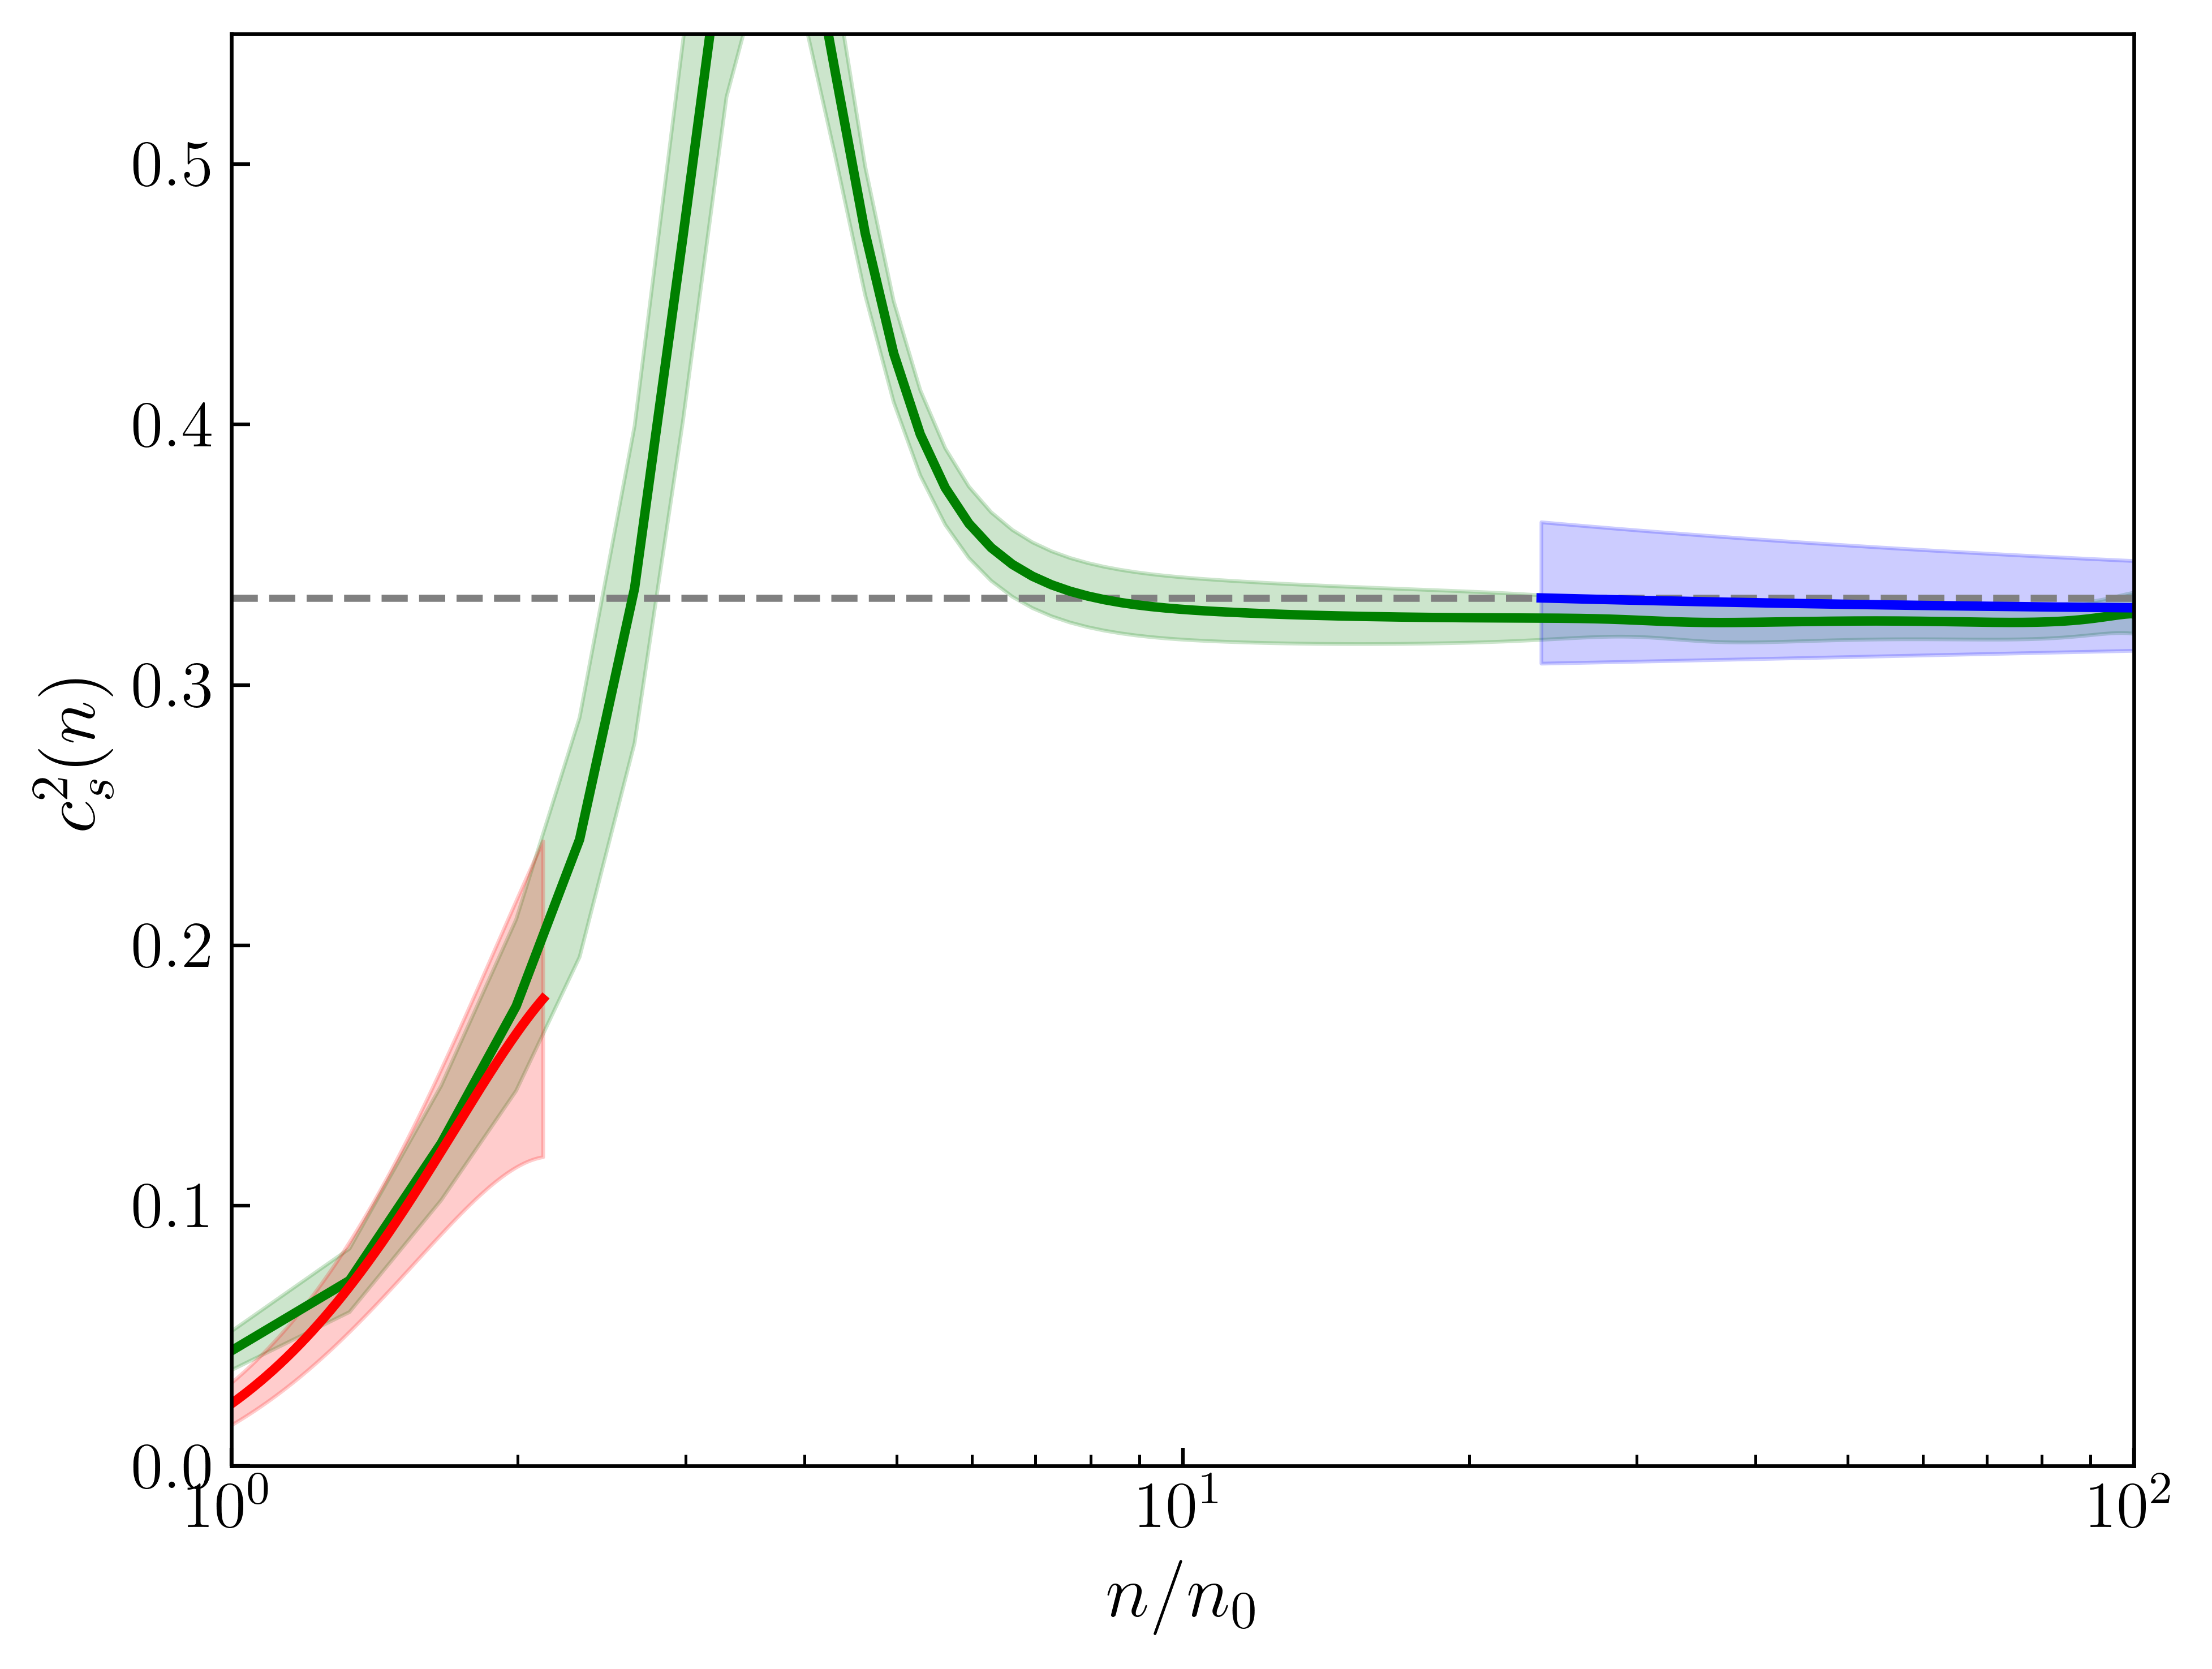

0.3272135771899767 0.32961941832535835
23.808528428093645


In [20]:
# plot the result quickly (noting the issue with scaling back out of P/P_FG)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 600   # change for paper plots
mpl.rcParams['font.size'] = 8
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
WIDE_IMG_WIDTH = 800
NARROW_IMG_WIDTH = 400

plt.axhline(y=0.333333, color='grey', linestyle='dashed')

plt.plot(density_test/n0, cs2_mean, color='g', linewidth=2, label=r'Mixed model')
plt.fill_between(density_test/n0, cs2_lower, cs2_upper, color='g', alpha=0.2)

# plot the result from chiral to see differences
npzfile = np.load('speedofsoundchiral.npz')
chiral_mean = npzfile['mean']
chiral_std = npzfile['std']
chiral_dens = npzfile['density']
plt.plot(chiral_dens/n0, chiral_mean[:,3], color='red', linewidth=2, label=r'ChEFT')
plt.fill_between(chiral_dens/n0, chiral_mean[:,3]+chiral_std[:,3], chiral_mean[:,3]-chiral_std[:,3], alpha=0.2, color='red')

# plot the result from pqcd to see differences
npzfile2 = np.load('pqcd_cs2_1.0.npz')
pqcd_cs2 = npzfile2['mean']
pqcd_dens = npzfile2['density']
pqcd_lower = npzfile2['lower']
pqcd_upper = npzfile2['upper']
plt.plot(pqcd_dens[56:]/n0, pqcd_cs2[56:], color='blue', linewidth=2, label=r'pQCD')
plt.fill_between(pqcd_dens[56:]/n0, pqcd_lower[56:], pqcd_upper[56:], color='blue', alpha=0.2)

# plot individual calculation from pQCD as well (using same method, but no energy density integration)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 0.55)
plt.xlabel(r'$n/n_{0}$', fontsize=16)
plt.ylabel(r'$c_{s}^{2}(n)$', fontsize=16)
plt.xscale('log')

# set up the labels
ax.text(0.5,0.5, r'$\chi$EFT', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
plt.show()

print(cs2_mean[-1], pqcd_cs2[-1])
print(pqcd_dens[56]/n0)

## Bayesian Model Mixing with a GP <a id="bmm_gp"></a>

### Pressure calculation

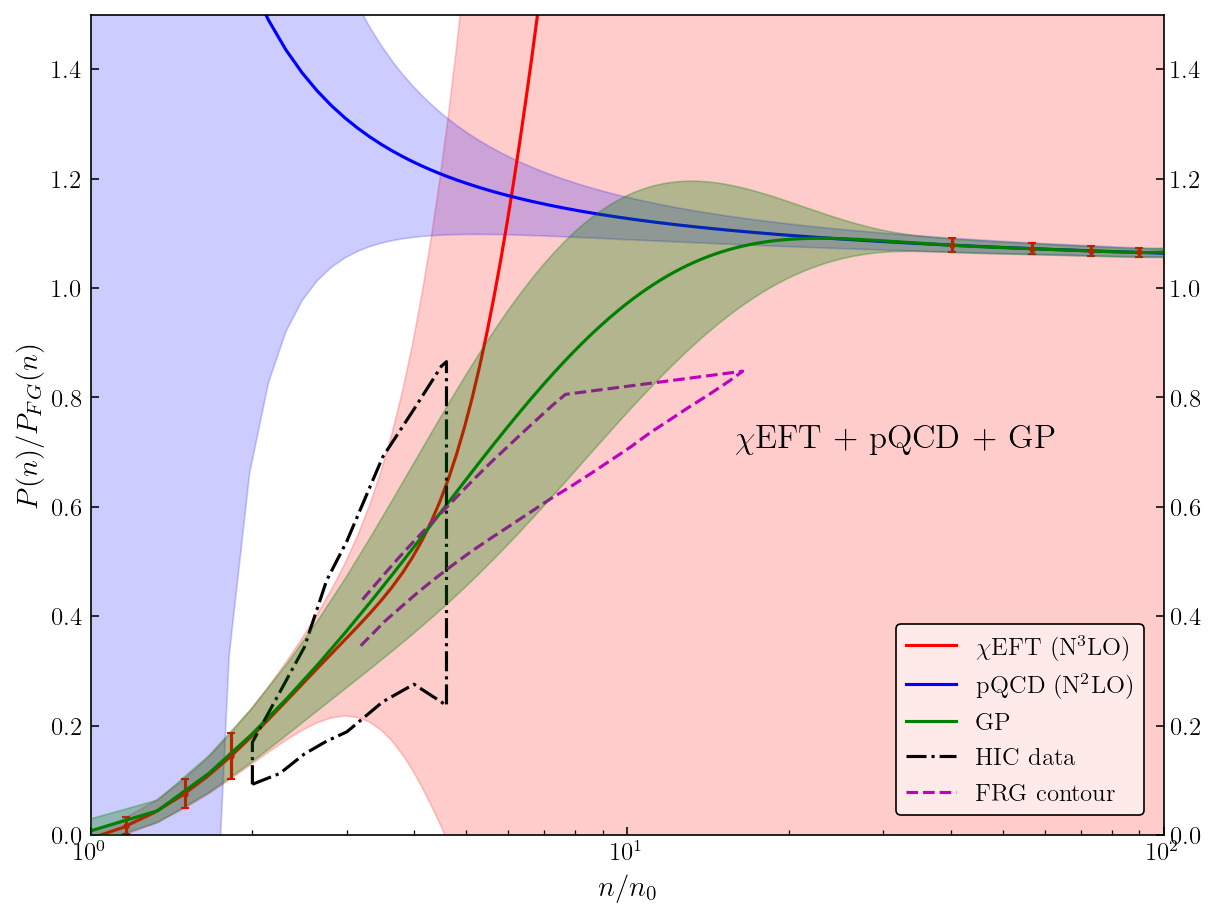

In [24]:
# import the data from the ChEFT, pQCD files
chiral_result = np.load('pressure_chiral_data_scaled_cpk.npz')
pqcd_result = np.load('pressure_pqcd_data_scaled_expQ.npz')

# plot BMM result
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(1.0, max(density/n0))
ax.set_ylim(0.0,1.5)
ax.tick_params(axis='both', which='major', labelsize=12, labelright=True, right=True)
ax.tick_params(axis='both', which='minor', labelsize=10, labelright=True)
ax.text(0.9,0.5, r'$\chi$EFT + pQCD + GP', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)

colors = ['r', 'b', 'g']
labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed model']

# assign means and std devs for easier use
mean_chiral = chiral_result['mean'][:,3]
mean_pqcd = pqcd_result['mean'][:,2]
std_dev_chiral = chiral_result['std_dev'][:,3]
std_dev_pqcd = pqcd_result['std_dev'][:,2]

# model means
ax.plot(chiral_result['density']/n0, chiral_result['mean'][:,3], color=colors[0], label=labels[0])
ax.plot(pqcd_result['density']/n0, pqcd_result['mean'][:,2], color=colors[1], label=labels[1])

# PPD mean (testing data array)
ax.plot(gp_result['density']/n0, gp_result['mean'], color='g', label='GP')

# model uncertainties
ax.fill_between(chiral_result['density']/n0, mean_chiral - 1.0*std_dev_chiral, mean_chiral + 1.0*std_dev_chiral, color=colors[0], alpha=0.2)
ax.fill_between(pqcd_result['density']/n0, mean_pqcd - 1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                color=colors[1], alpha=0.2)

# PPD band (testing data array)
ax.fill_between(gp_result['density']/n0, gp_result['mean']-1.0*gp_result['std'], gp_result['mean']+1.0*gp_result['std'],
                       zorder=5, facecolor='g', edgecolor='g', alpha=0.3)

# frg unscaling
pressure_free = np.zeros([len(df_frg['n/n0'])])
p_fg = np.zeros([len(density_test)])
hbarc = 197.327 # MeV fm

# contour kf_s calculated here
contour_kf_s_fg = fermi_momentum(density=density_test, degeneracy=4)
contour_kf_s = fermi_momentum(density=0.16*df_frg['n/n0'], degeneracy=4)

for i in range(len(df_frg['n/n0'])):
    pressure_free[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s[i]**4.0))*(hbarc)
p_fg = pqcd_convert_arr
    
# unscale FRG
frg_unscaled = df_frg['P/P_free']*pressure_free
ax.plot(df['Density/n0'], df['p_pfg'], color='k', linestyle='dashdot', label='HIC data')
ax.plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', label='FRG contour')

# plot the training points
plt.errorbar(tr_data["density"]/n0, tr_data["mean"], yerr=tr_data["std"], \
             color='red', fmt='o', markersize=2, capsize=2)

# legend
ax.set_xscale('log')
ax.legend(loc='lower right', fontsize=12)
plt.show()

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="cs2_gp"></a>

In [25]:
# want to only use data above saturation
dens_cs2 = density_test
print(dens_cs2[0])

0.16


In [26]:
# unscale the variables using what we've got for now and store in a dict
pres_dict = {
    'mean': gp_result['mean']*p_fg,
    'std_dev': gp_result['std']*p_fg
}

# 0.05 values for this calculation
en_0 = 147.9713083195 #194.17600341520549 #46.52745253488445 # when rest mass is included for ChEFT at 0.20 fm^-3 # 0.05 fm^-3
en_0_lower = 147.835229682 #193.83220928426712 #46.525
en_0_upper = 148.1073869568 #194.51979754614385 #46.530

edens_dict = {
    'mean': en_0, 
    'lower': en_0_lower,
    'upper': en_0_upper
}

# call speed of sound function
cs2, edens_info = speed_of_sound(dens_cs2, pres_dict, edens_dict)

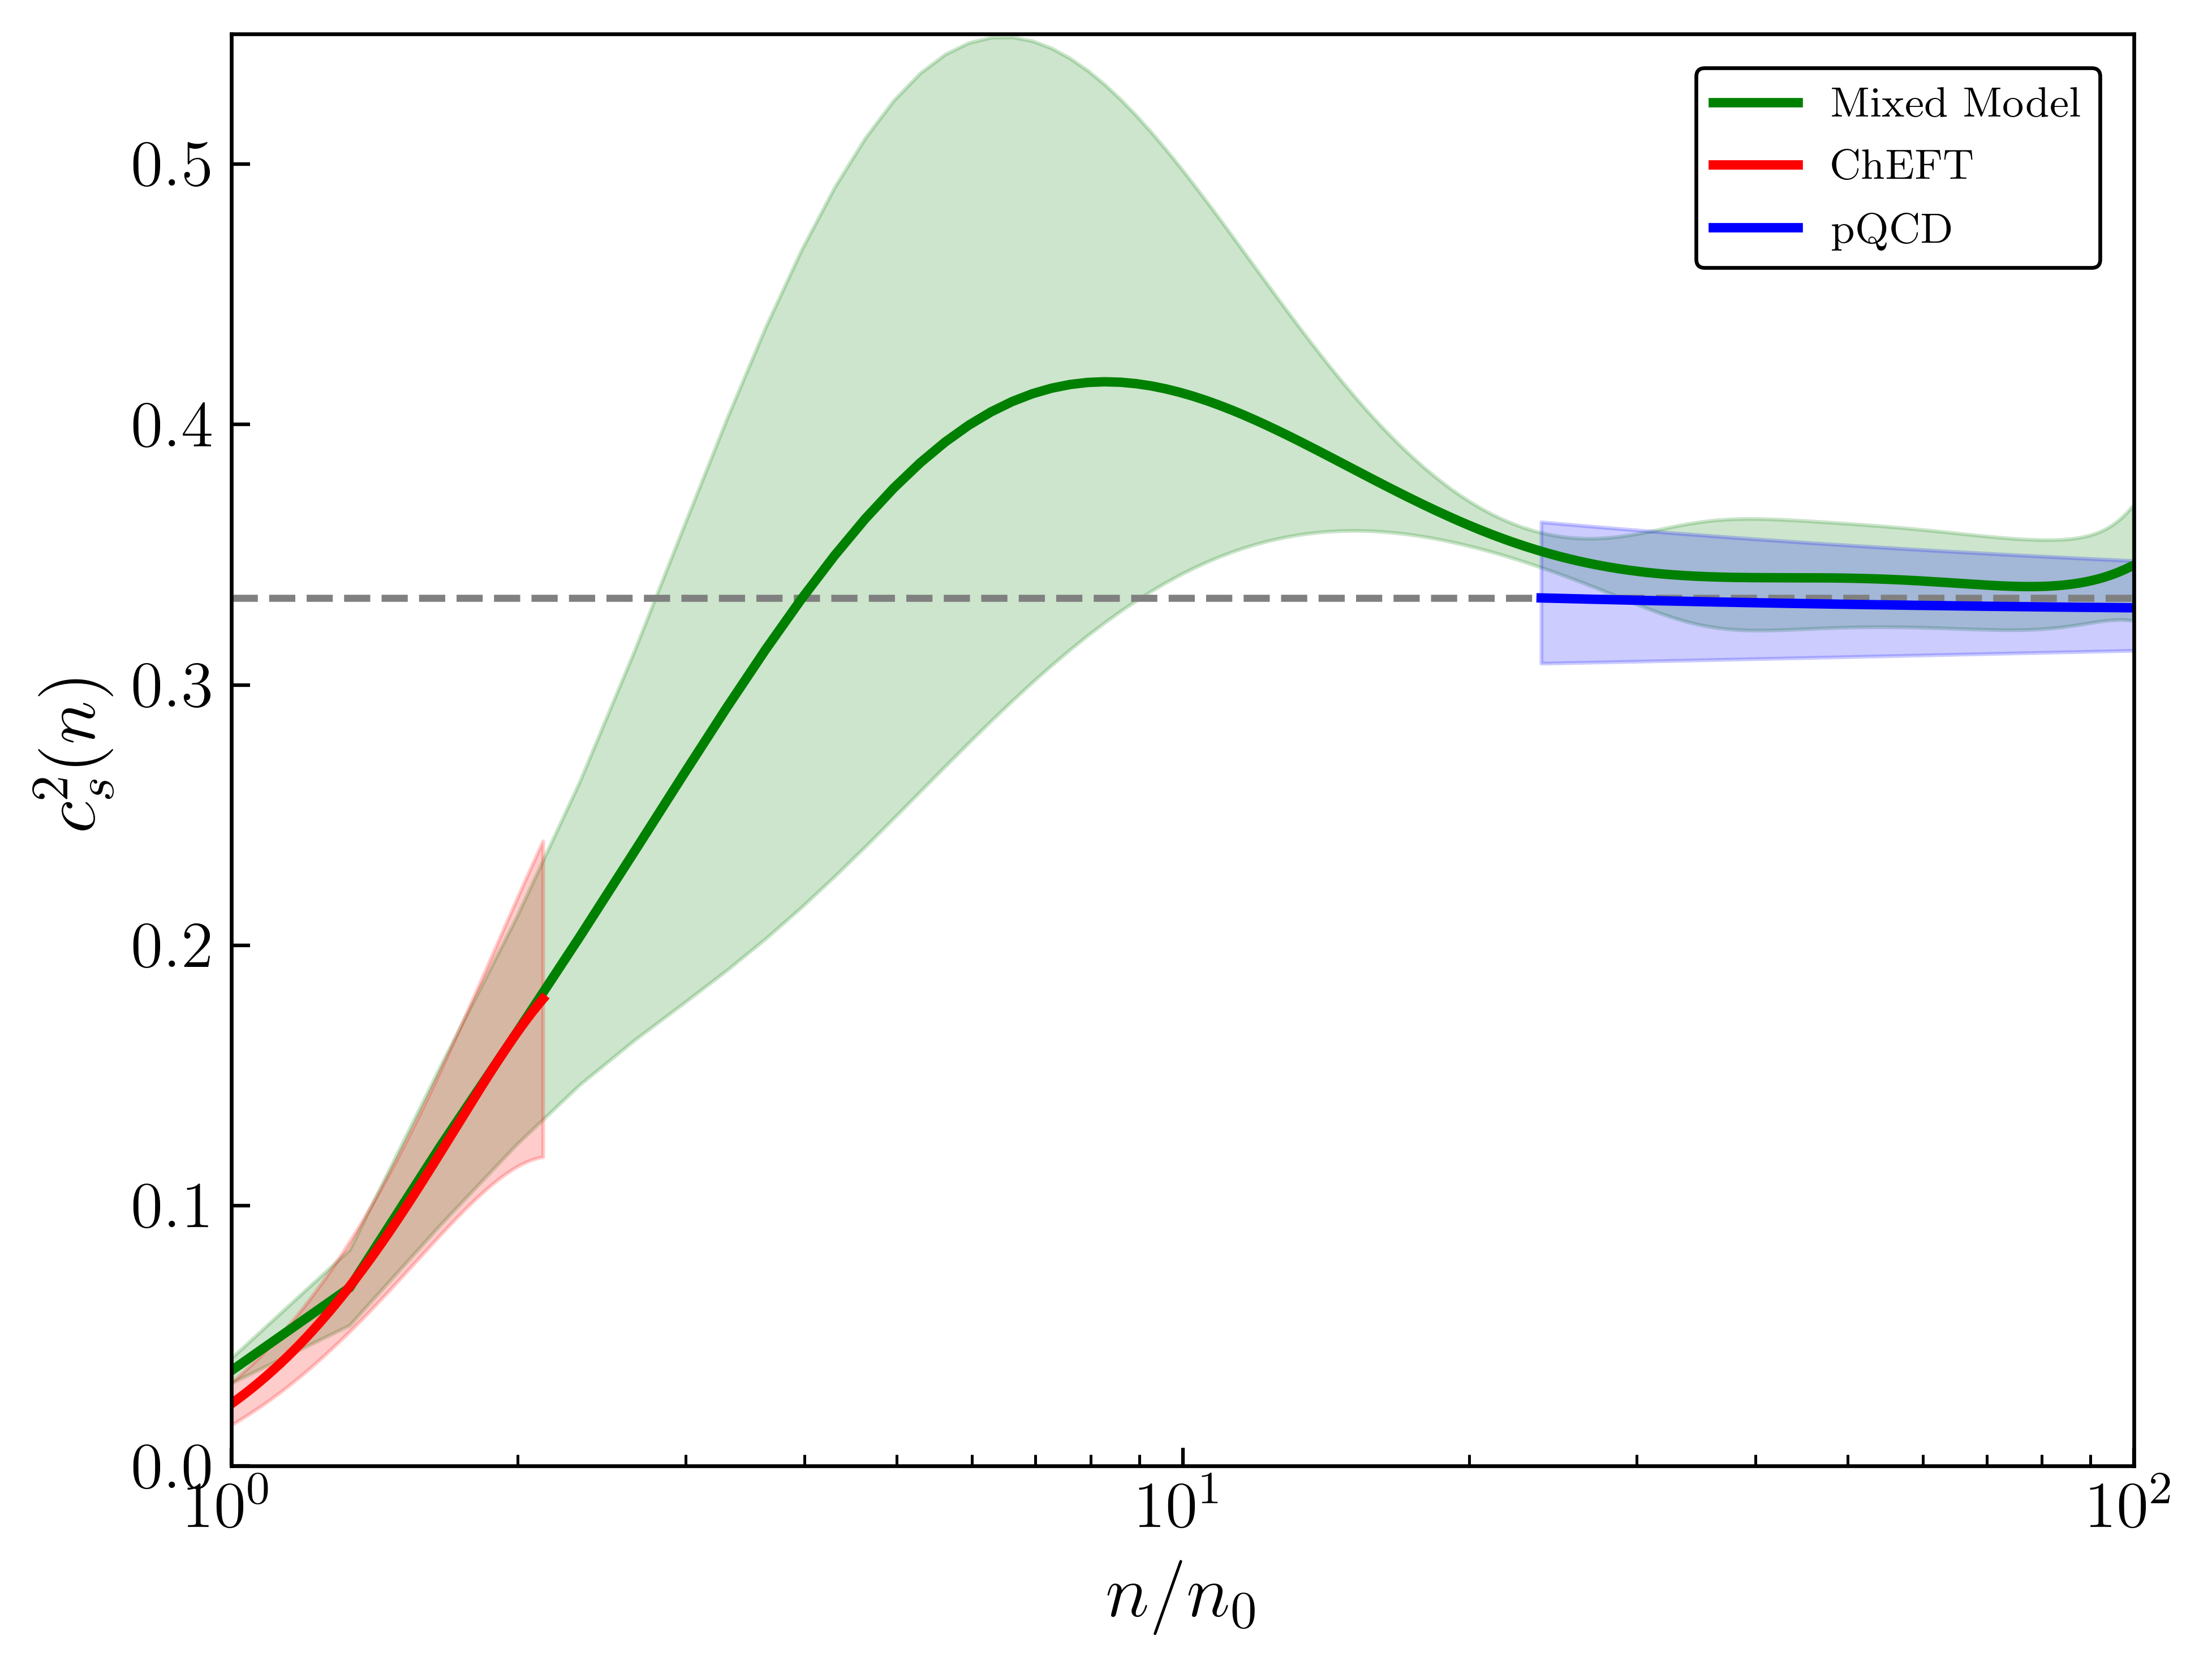

In [27]:
# speed of sound
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 600   # change for paper plots
mpl.rcParams['font.size'] = 8
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
WIDE_IMG_WIDTH = 800
NARROW_IMG_WIDTH = 400

plt.axhline(y=0.333333, color='grey', linestyle='dashed')

# old constraint :60
plt.plot(dens_cs2/n0, cs2['mean'], color='g', linewidth=2, label=r'Mixed Model')
plt.fill_between(dens_cs2/n0, cs2['lower'], cs2['upper'], color='g', alpha=0.2)

# plot the result from chiral to see differences
npzfile = np.load('speedofsoundchiral.npz')
chiral_mean = npzfile['mean']
chiral_std = npzfile['std']
chiral_dens = npzfile['density']
plt.plot(chiral_dens/n0, chiral_mean[:,3], color='red', linewidth=2, label=r'ChEFT')
plt.fill_between(chiral_dens/n0, chiral_mean[:,3]+chiral_std[:,3], chiral_mean[:,3]-chiral_std[:,3], alpha=0.2, color='red')

# plot the result from pqcd to see differences
npzfile2 = np.load('pqcd_cs2_1.0.npz')
pqcd_cs2 = npzfile2['mean']
pqcd_dens = npzfile2['density']
pqcd_lower = npzfile2['lower']
pqcd_upper = npzfile2['upper']
plt.plot(pqcd_dens[56:]/n0, pqcd_cs2[56:], color='blue', linewidth=2, label=r'pQCD')
plt.fill_between(pqcd_dens[56:]/n0, pqcd_lower[56:], pqcd_upper[56:], color='blue', alpha=0.2)

# plot individual calculation from pQCD as well (using same method, but no energy density integration)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 0.55)
plt.xlabel(r'$n/n_{0}$', fontsize=16)
plt.ylabel(r'$c_{s}^{2}(n)$', fontsize=16)
plt.xscale('log')
plt.legend()
plt.show()

## Creating the poster plot

Now we need to use both the $P(n)$ result and the $c_{s}^{2}(n)$ result in one set of subplots so that we can present them side-by-side in the poster for the INPP Open House. We can simply call the data files and load them into the plot here, if we wish to avoid any running of the main code above, since we are only using the GP result for the poster and not the totally mixed result.

In [23]:
# load the data for both plots
poster_chi = np.load('data/eos_data/pressure_chiral_data_scaled_cpk.npz')
poster_pqcd = np.load('data/eos_data/pressure_pqcd_data_scaled_expQ.npz')
poster_gp = np.load('data/gpjaxemcee_data/gp_ls2_log.npz')      # switch this out to other ls and pick one
poster_cs2_chi = np.load('data/eos_data/speedofsoundchiral.npz')
poster_cs2_pqcd = np.load('data/eos_data/pqcd_cs2_1.0.npz')

# contour plot data
df = pd.read_csv('data/contour_scaled.csv')
df_frg = pd.read_csv('data/frg_data_pressure.csv')
df_hhic = pd.read_csv('data/hic_data_huth.csv')
df_hfrg = pd.read_csv('data/frg_data_huth.csv')

In [24]:
# set up other variables
n0 = 0.16 # fm^-3

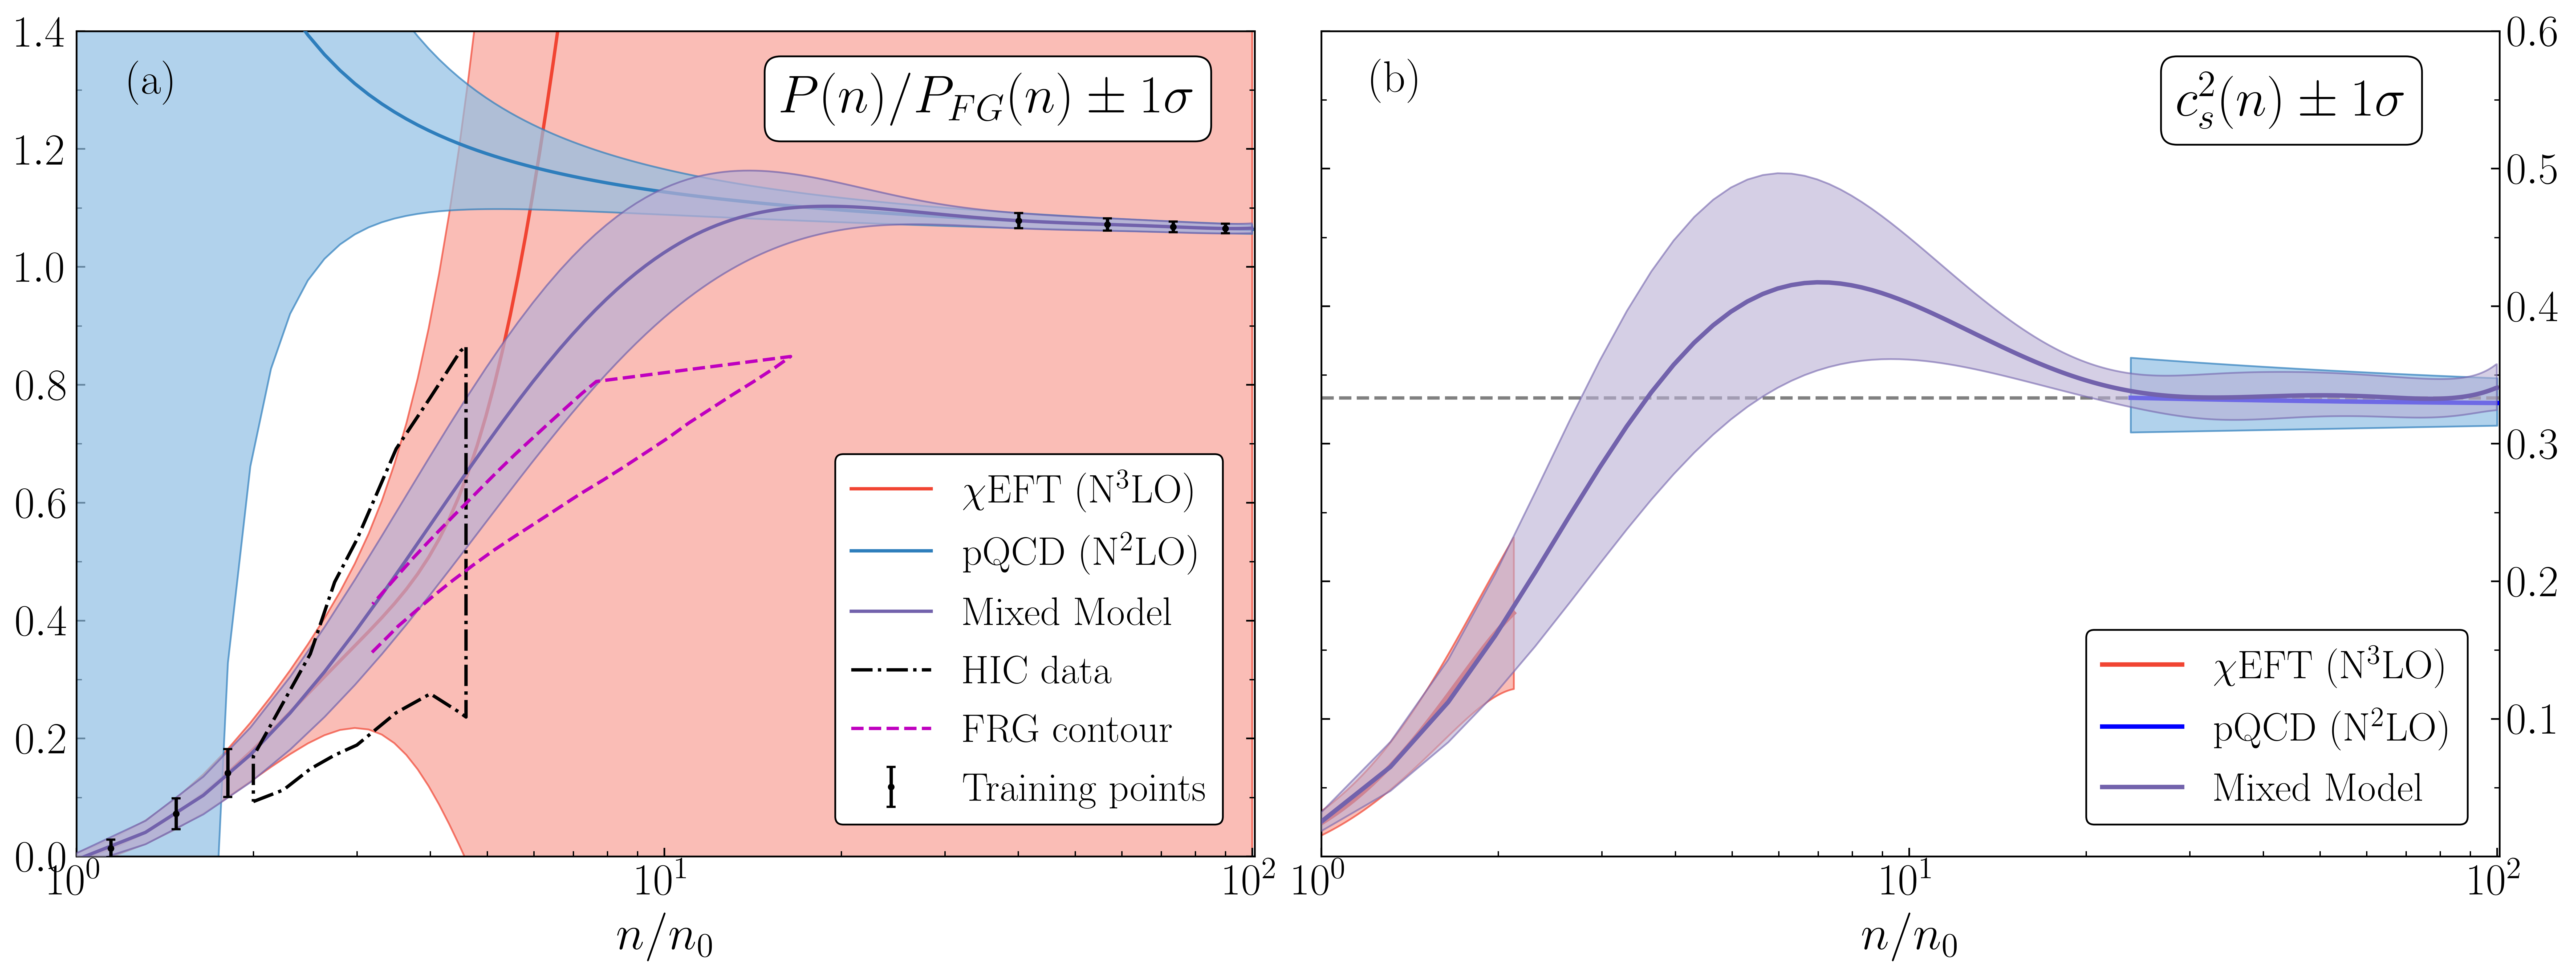

In [25]:
# set up the plot requirements
fig, ax = plt.subplots(1, 2, figsize=(16,6), dpi=600, sharex='col')
fig.patch.set_alpha(0.0)
ax[0].set_xlim(1.00, max(density/n0)+1.)
ax[0].set_ylim(0.0,1.4)
ax[0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[0].xaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0].text(1.5, 1.35, r'(a)', ha='right', va='top', fontsize=20)
ax[0].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[0].set_xscale('log')

ax[1].set_xlim(1., max(density/n0)+1.)
ax[1].set_ylim(1e-6,0.6)
ax[1].xaxis.set_major_locator(MultipleLocator(10))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1].text(1.5, 0.58, r'(b)', ha='right', va='top', fontsize=20)
ax[1].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1].set_xscale('log')

orders = [0,1,2]

# plotting assistance
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# assign means and std devs for easier use
mean_chiral = poster_chi['mean'][:,3]
mean_pqcd = poster_pqcd['mean'][:,2]
std_dev_chiral = poster_chi['std_dev'][:,3]
std_dev_pqcd = poster_pqcd['std_dev'][:,2]

# pressure data

# model means and uncertainties
ax[0].fill_between(poster_chi['density']/n0, mean_chiral - 1.0*std_dev_chiral, mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[0].plot(poster_chi['density']/n0, poster_chi['mean'][:,3], color=colors[0], zorder=1, label=labels[0])

ax[0].fill_between(poster_pqcd['density']/n0, mean_pqcd - 1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[0].plot(poster_pqcd['density']/n0, poster_pqcd['mean'][:,2], zorder=3, color=colors[1], label=labels[1])

# PPD band (testing data array)
ax[0].fill_between(poster_gp['density']/n0, poster_gp['mean']-1.0*poster_gp['std'], poster_gp['mean']+ \
                   1.0*poster_gp['std'],
                       zorder=5, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[0].plot(poster_gp['density']/n0, poster_gp['mean'], color=colors[2], zorder=10, label='Mixed Model')

# frg unscaling
pressure_free = np.zeros([len(df_frg['n/n0'])])
p_fg = np.zeros([len(density_test)])
hbarc = 197.327 # MeV fm

# contour kf_s calculated here
contour_kf_s_fg = fermi_momentum(density=density_test, degeneracy=4)
contour_kf_s = fermi_momentum(density=0.16*df_frg['n/n0'], degeneracy=4)

for i in range(len(df_frg['n/n0'])):
    pressure_free[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s[i]**4.0))*(hbarc)
p_fg = pqcd_convert_arr
    
# unscale FRG
frg_unscaled = df_frg['P/P_free']*pressure_free
ax[0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', zorder=10, label='HIC data')
ax[0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', zorder=10, label='FRG contour')

# plot the training points
ax[0].errorbar(tr_data["density"]/n0, tr_data["mean"], yerr=tr_data["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[0].legend(loc='lower right', facecolor='w', fontsize=18)

# speed of sound data 
ax[1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[1].fill_between(poster_cs2_chi['density']/n0, poster_cs2_chi['mean'][:,3]+poster_cs2_chi['std'][:,3], \
                 poster_cs2_chi['mean'][:,3]-poster_cs2_chi['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[1].plot(poster_cs2_chi['density']/n0, poster_cs2_chi['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
npzfile2 = np.load('pqcd_cs2_1.0.npz')
pqcd_cs2 = npzfile2['mean']
pqcd_dens = npzfile2['density']
pqcd_lower = npzfile2['lower']
pqcd_upper = npzfile2['upper']
ax[1].fill_between(pqcd_dens[56:]/n0, pqcd_lower[56:], pqcd_upper[56:], zorder=2, \
                   facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)
ax[1].plot(pqcd_dens[56:]/n0, pqcd_cs2[56:], color='blue', linewidth=2, zorder=3, label=r'pQCD (N$^2$LO)')

# GP data
ax[1].fill_between(density_test/n0, cs2['lower'], cs2['upper'], zorder=4, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[1].plot(density_test/n0, cs2['mean'], color=colors[2], linewidth=2, zorder=5, label=r'Mixed Model')

ax[1].legend(loc='lower right', facecolor='w', fontsize=18)
plt.show()
#fig.savefig('subplot_p_cs2.PNG', bbox_inches='tight')